# Characterize within-host variants

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import requests
import pandas as pd 
import numpy as np
    
import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors
s_color = "#A5CDA2"
ns_color = "#0E7908"
stop_color = "#073C04"
fs_color = "#00357D"
fs_stop_color = "#00142F"

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [91]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [92]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [102]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; sample/tube 6, UW-30, has an snv at basically every single site after a certain 
# point in the genome. it has 418 SNVs!!! I'm excluding it; finally, I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors as it is 
# a very clear outlier
samples_to_ignore = ["N_transcript","6", "127"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [103]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only['minor_frequency'] >= float(variant_percent)]
indels_only = indels_only[indels_only['minor_frequency'] >= float(variant_percent)]

In [104]:
pd.set_option('display.max_columns', 35)

#snvs_only.to_csv("/Users/lmoncla/src/ncov-WI-within-host/data/all-WI-snvs.tsv", sep="\t")
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,orf1ab,C>T,Ser2839Ser,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,2839,Ser,Ser,C,T,C8782T,0.08350,T,C,Ser,Ser,T8782C,orf1ab_Ser2839Ser
11,21,orf1ab_G>A_Val5373Ile_missense,16381.0,0.9115,0.9512,0.93135,53,orf1ab,G>A,Val5373Ile,missense,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,5373,Val,Ile,G,A,G16381A,0.06865,A,G,Ile,Val,A16381G,orf1ab_Ile5373Val
12,22,orf1ab_T>C_Thr5871Thr_synonymous,17877.0,0.9542,0.9487,0.95145,53,orf1ab,T>C,Thr5871Thr,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,5871,Thr,Thr,T,C,T17877C,0.04855,C,T,Thr,Thr,C17877T,orf1ab_Thr5871Thr
14,27,orf1ab_C>T_Phe6684Phe_synonymous,20316.0,0.9173,0.9239,0.92060,53,orf1ab,C>T,Phe6684Phe,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,6684,Phe,Phe,C,T,C20316T,0.07940,T,C,Phe,Phe,T20316C,orf1ab_Phe6684Phe
15,33,ORF3a_G>T_Pro36Pro_synonymous,25500.0,0.9557,0.9679,0.96180,53,ORF3a,G>T,Pro36Pro,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,36,Pro,Pro,G,T,G25500T,0.03820,T,G,Pro,Pro,T25500G,ORF3a_Pro36Pro


In [105]:
sloth = snvs_only[snvs_only['minor_nuc_muts'] == "T241C"]
sloth.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
0,6,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.9355,0.8334,0.88445,1144,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-747/2020,Dane County,20C,adjacent,a,snv,NA,NA,NA,C,T,C241T,0.11555,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
3,9,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.7705,0.9239,0.84720,1353,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-895/2020,Dane County,20C,adjacent,a,snv,NA,NA,NA,C,T,C241T,0.15280,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
0,0,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.9845,0.9421,0.96330,80,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-86/2020,Dane County,20A,adjacent,a,snv,NA,NA,NA,C,T,C241T,0.03670,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
1,9,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.8995,0.8888,0.89415,79,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-85/2020,Dane County,20A,adjacent,a,snv,NA,NA,NA,C,T,C241T,0.10585,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
3,7,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.5373,0.5507,0.54400,849,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-536/2020,Dane County,20C,adjacent,a,snv,NA,NA,NA,C,T,C241T,0.45600,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA


In [106]:
snvs_only.columns

Index(['Unnamed: 0', 'SNP', 'POS_x', 'rep1_percent', 'rep2_percent',
       'frequency', 'sampleid', 'gene', 'nt_change', 'aa_change', 'annotation',
       'strain_name', 'location', 'clade', 'homopolymer', 'homopolymer_base',
       'type_of_variant', 'aa_site', 'wt_aa', 'mut_aa', 'nt_ref', 'nt_mut',
       'nuc_muts', 'minor_frequency', 'consensus_base', 'minor_base',
       'consensus_aa', 'minor_aa', 'minor_nuc_muts', 'minor_aa_muts'],
      dtype='object')

In [107]:
print(set(snvs_only['annotation'].tolist()))
print(set(indels_only['annotation'].tolist()))

{'intergenic_region', 'synonymous', 'missense'}
{'intergenic_region', 'frameshift&stop', 'conservative-inframe-deletion', 'frameshift'}


In [108]:
snvs_to_query = set(snvs_only['minor_nuc_muts'])
indels_to_query = set(indels_only['minor_nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))
print("\ntotal samples with a variant:")
print(len(set(all_intersection_variants['strain_name'].tolist())))

229
25
254

total samples with a variant:
141


## Notes: 

* when using variants called at a frequency of at least 1%, we get 469 SNVs and 137 indels, for a total of 606 variants
* when using variants called at a frequency of at least 3%, we get 292 SNVs, 72 indels, for a total of 364 variants

## How many variants are there per sample?

On average, and a distribution

In [109]:
def return_number_variants_per_sample(df):
    # output number of SNVs per sample
    snvs_dict = {}
    snvs_list = []
    total_snvs = 0
    
    print("printing samples with >50 variants")
    print("strain name\tnumber variants\t sample id")
    for i in set(df['strain_name'].tolist()):
        x = df[df['strain_name'] == i]
        snvs_dict[i] = [len(x)]
        snvs_list.append(len(x))
        total_snvs += len(x)
        sampleid = list(set(x['sampleid'].tolist()))[0]
        
        if len(x) >= 15:
            print(i, len(x), sampleid)
    
    mean_number_snvs = total_snvs/(len(snvs_list))
    nparray = np.asarray(snvs_list)
    stdev = nparray.std()
    median = np.median(nparray)
    percentile_95 = np.percentile(nparray,97.5)
    percentile_5 = np.percentile(nparray,2.5)
    max_snvs = max(snvs_list)
    min_snvs = min(snvs_list)
    print("mean and st dev: ",mean_number_snvs, stdev)
    print("median: ", median)
    print("95th percentile: ",percentile_5,percentile_95)
    print("max:",max_snvs, "min:",min_snvs)
    print(len(snvs_list))
    
    return(snvs_dict)

In [110]:
print("snvs")
snvs_dict = return_number_variants_per_sample(snvs_only)
print("indels")
indels_dict = return_number_variants_per_sample(indels_only)

snvs
printing samples with >50 variants
strain name	number variants	 sample id
USA/WI-UW-722/2020 18 1104
USA/WI-UW-586/2020 27 916
USA/WI-UW-756/2020 16 1157
mean and st dev:  4.754098360655738 4.151459303784745
median:  4.0
95th percentile:  1.0 14.0
max: 27 min: 1
122
indels
printing samples with >50 variants
strain name	number variants	 sample id
mean and st dev:  2.1844660194174756 1.103811339018716
median:  2.0
95th percentile:  1.0 4.0
max: 7 min: 1
103


In [111]:
# convert to dataframes and combine
snvs_per_sample_df = pd.DataFrame.from_dict(snvs_dict, orient="index")
snvs_per_sample_df.reset_index(inplace=True)
snvs_per_sample_df.columns = ['strain','SNVs']
indels_per_sample_df = pd.DataFrame.from_dict(indels_dict, orient="index")
indels_per_sample_df.reset_index(inplace=True)
indels_per_sample_df.columns = ['strain','indels']

variants_per_sample_df = snvs_per_sample_df.merge(indels_per_sample_df, on='strain', how='outer')
variants_per_sample_df = variants_per_sample_df.fillna(0)
variants_per_sample_df['variants'] = variants_per_sample_df['SNVs'] + variants_per_sample_df['indels']
variants_per_sample_df.head()

,strain,SNVs,indels,variants
0,USA/WI-UW-367/2020,1.0,2.0,3.0
1,USA/WI-UW-24/2020,1.0,2.0,3.0
2,USA/WI-UW-432/2020,5.0,0.0,5.0
3,USA/WI-UW-246/2020,6.0,1.0,7.0
4,USA/WI-UW-76/2020,1.0,2.0,3.0


In [112]:
# convert to counts of number of samples that have x SNVs
snv_counts = pd.DataFrame(variants_per_sample_df['SNVs'].value_counts())
snv_counts.reset_index(inplace=True)
snv_counts.columns = ['number_of_SNVs','number_of_samples']

indel_counts = pd.DataFrame(variants_per_sample_df['indels'].value_counts())
indel_counts.reset_index(inplace=True)
indel_counts.columns = ['number_of_indels','number_of_samples']

variant_counts = pd.DataFrame(variants_per_sample_df['variants'].value_counts())
variant_counts.reset_index(inplace=True)
variant_counts.columns = ['number_of_variants','number_of_samples']
variant_counts.head()

,number_of_variants,number_of_samples
0,3.0,25
1,4.0,20
2,2.0,15
3,6.0,14
4,5.0,14


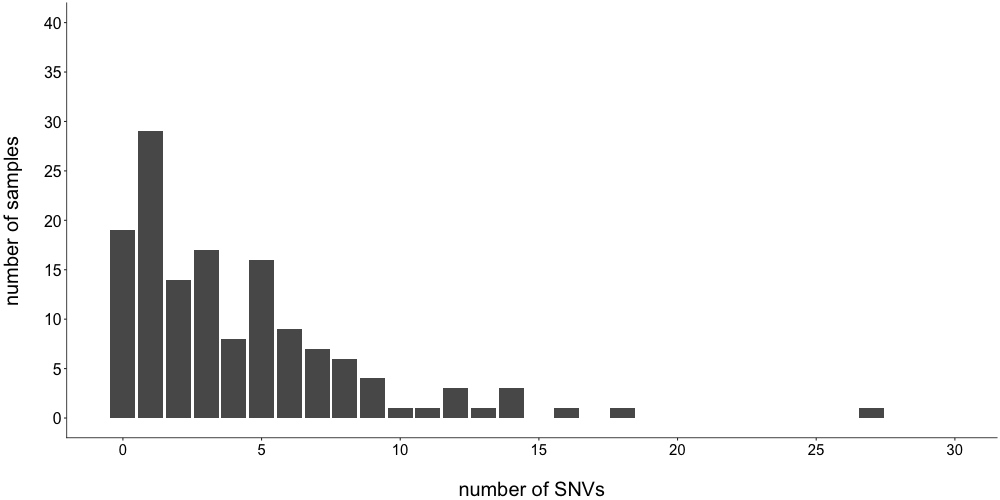

In [115]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,snv_counts,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)


output_filename = paste("SNVs-per-sample-",variant_percent,"percent-",current_date,".pdf", sep="")

p1 <- ggplot(snv_counts, aes(x=number_of_SNVs, y=number_of_samples))+
    geom_col()+
    #scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,40), breaks=seq(0,40,5))+
    scale_x_continuous(breaks=seq(0,30,5), limits=c(-0.5,30))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, vjust=0.5, size=15, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nnumber of SNVs",y="number of samples\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p1, width = 6, height = 4, path="../figures/individual-pdfs/")
p1

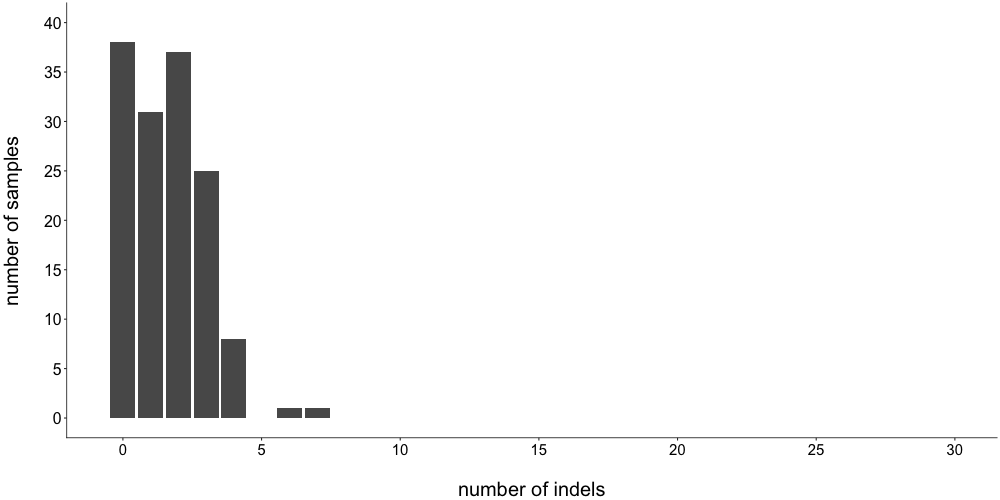

In [116]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,indel_counts,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)


output_filename = paste("indels-per-sample-",variant_percent,"percent-",current_date,".pdf", sep="")

p1 <- ggplot(indel_counts, aes(x=number_of_indels, y=number_of_samples))+
    geom_col()+
    #scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,40), breaks=seq(0,40,5))+
    scale_x_continuous(breaks=seq(0,30,5), limits=c(-0.5,30))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, vjust=0.5, size=15, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nnumber of indels",y="number of samples\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p1, width = 6, height = 4, path="../figures/individual-pdfs/")
p1

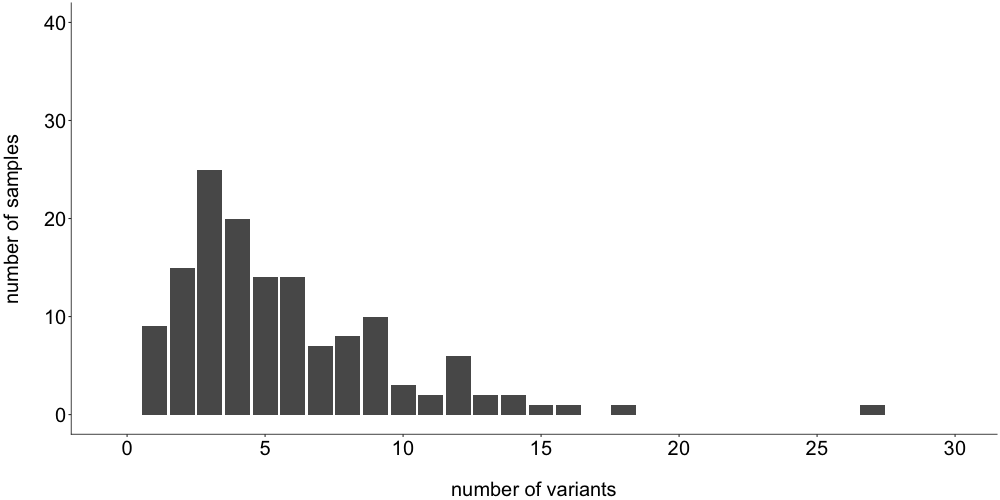

In [123]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,variant_counts,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)


output_filename = paste("variants-per-sample-",variant_percent,"percent-",current_date,".pdf", sep="")

p1 <- ggplot(variant_counts, aes(x=number_of_variants, y=number_of_samples))+
    geom_col()+
    #scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,40), breaks=seq(0,40,10))+
    scale_x_continuous(breaks=seq(0,30,5), limits=c(-0.5,30))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=20, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, vjust=0.5, size=20, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nnumber of variants",y="number of samples\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p1, width = 6, height = 4, path="../figures/individual-pdfs/")
p1